# Bottom property bias - WOA18

This notebook plots the bottom property bias of a model simulation vs. the World Ocean Atlas (2018) gridded hydrography product.

For the WOA product, we find the bottom-most data value in each grid column.

In [1]:
import os
import datetime

In [2]:
config = {
    "startyr": "1975",
    "endyr": "2015",
    "dora_id": "odiv-368",
    "pathPP": None,
}

MAR will pass for environment variables to the script when running via the web engine:

* `MAR_STARTYR`: Beginning year of analysis from model
* `MAR_ENDYR`: Ending year of analysis from model
* `MAR_DORA_ID`: The experiment ID in the database
* `MAR_PATHPP`: The top-level path to the post-processing experiment directory of the experiment

The block below will use values passed in by Dora but default to the values defined above in `config`. This is useful for interactive usage and debugging.

If executed from Dora, there will also be a `DORA_EXECUTE` variable that is set.

In [3]:
for k, v in config.items():
    config[k] = (
        os.environ[f"MAR_{k.upper()}"]
        if f"MAR_{k.upper()}" in os.environ.keys()
        else v
    )

### Import Python Modules

In [4]:
import doralite
import glob
import momlevel
import subprocess

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from matplotlib.colors import ListedColormap, BoundaryNorm

In [5]:
# momgrid will use a directory of pre-computed weights that is used for calculating basic area-weighted statistics later
import momgrid
os.environ["MOMGRID_WEIGHTS_DIR"] = "/nbhome/John.Krasting/grid_weights"

### Definie Local Parameters

In [6]:
# Define some local variables. These are taken from the doralite object
# or they can be defined locally

experiment =  doralite.dora_metadata(config["dora_id"])
pathPP = experiment["pathPP"]
expName = experiment["expName"]

# Define start and end years
start = int(config["startyr"])
end = int(config["endyr"])

### Determine What Files to Load

In [7]:
# Determine what files are needed (leave this up to the developer for flexibility)
# This is an example of what someone might do:

component = "ocean_monthly"
static = f"{component}/{component}.static.nc"
varnames = ["tob", "sob"]

chunk = "5yr"
filelists = [
    sorted(glob.glob(f"{pathPP}{component}/ts/**/{chunk}/{component}.*.{varname}.nc", recursive=True))
    for varname in varnames
]
filelist = [e for fl in filelists for e in fl]

def is_in_range(file,start,end):
    start = int(start)
    end = int(end)
    target = set(list(range(start,end+1)))
    fname = os.path.basename(file)
    times = fname.split(".")[1]
    times = times.split("-")
    times = [int(x[0:4]) for x in times]
    candidate = set(list(range(times[0],times[1]+1)))
    return len(candidate.intersection(target)) > 0

filelist = [x for x in filelist if is_in_range(x,start,end)]
staticfile = f"{pathPP}/{static}"

_ = [print(x) for x in filelist]

/archive/Olga.Sergienko/fre_om5/FMS2023.01_om5_20231122/om5_b03_standard_GEBCO_BMv3Ant/gfdl.ncrc5-intel23-prod/pp/ocean_monthly/ts/monthly/5yr/ocean_monthly.197301-197712.tob.nc
/archive/Olga.Sergienko/fre_om5/FMS2023.01_om5_20231122/om5_b03_standard_GEBCO_BMv3Ant/gfdl.ncrc5-intel23-prod/pp/ocean_monthly/ts/monthly/5yr/ocean_monthly.197801-198212.tob.nc
/archive/Olga.Sergienko/fre_om5/FMS2023.01_om5_20231122/om5_b03_standard_GEBCO_BMv3Ant/gfdl.ncrc5-intel23-prod/pp/ocean_monthly/ts/monthly/5yr/ocean_monthly.198301-198712.tob.nc
/archive/Olga.Sergienko/fre_om5/FMS2023.01_om5_20231122/om5_b03_standard_GEBCO_BMv3Ant/gfdl.ncrc5-intel23-prod/pp/ocean_monthly/ts/monthly/5yr/ocean_monthly.198801-199212.tob.nc
/archive/Olga.Sergienko/fre_om5/FMS2023.01_om5_20231122/om5_b03_standard_GEBCO_BMv3Ant/gfdl.ncrc5-intel23-prod/pp/ocean_monthly/ts/monthly/5yr/ocean_monthly.199301-199712.tob.nc
/archive/Olga.Sergienko/fre_om5/FMS2023.01_om5_20231122/om5_b03_standard_GEBCO_BMv3Ant/gfdl.ncrc5-intel23-prod

### DMgetting Files

Dora cannot issue calls to dmget

In [8]:
if not "DORA_EXECUTE" in os.environ.keys():
    print("Calling dmget on files ...")
    cmd = ["dmget"]+filelist+[staticfile]
    _ = subprocess.check_output(cmd)

Calling dmget on files ...


### Load model data and grid

In [9]:
ds = momgrid.Gridset(filelist, force_symmetric=True, return_corners=True)
model_type = ds.model
ds = ds.data.sel(time=slice(f"{str(start).zfill(4)}-01-01",f"{str(end).zfill(4)}-12-31"))

### Load observational data (if needed)

Note that Dora only mounts `/archive`, `/nbhome`, and `/home`

In [10]:
if "om4" in model_type:
    dsobs = "/archive/jpk/datasets/OM5/obs/WOA18/WOA18_z_35level_OM4_1080x1440_annual_v20240224.nc"
elif "om5" in model_type:
    dsobs = "/archive/jpk/datasets/OM5/obs/WOA18/WOA18_z_35level_OM5_1161x1440_annual_v20240224.nc"
else:
    raise ValueError(f"Model type {model_type} not supported")

dsobs = xr.open_dataset(dsobs).isel(time=0)

# Get select bottom most numerical value
dsobs['tob'] = dsobs['thetao'].isel(z_l=np.isnan(dsobs['thetao']).argmax("z_l")-1)
dsobs['sob'] = dsobs['so'].isel(z_l=np.isnan(dsobs['so']).argmax("z_l")-1)

### Define some helper function for the plots

In [11]:
def gen_levs_and_cmap(start,end,delta,cmap="RdBu_r"):
    """Generates a difference colormap centered on white"""
    boundaries = np.arange(start,end,delta)
    levels = (boundaries[0:-1] + boundaries[1:]) / 2.
    base_cmap = plt.get_cmap(cmap)
    colors = base_cmap(np.linspace(0, 1, len(levels)))
    colors[[int(len(colors) / 2) - 1]] = [1, 1, 1, 1]
    colors[[int(len(colors) / 2)]] = [1, 1, 1, 1]
    cmap = ListedColormap(colors)
    norm = BoundaryNorm(boundaries, cmap.N, clip=True)
    return (cmap, norm, boundaries)

In [12]:
def set_annotaions(ax, title):
    _ = ax.set_xticks([])
    _ = ax.set_yticks([])
    _ = ax.text(0.0,1.06, title, weight="bold", fontsize=12, transform=ax.transAxes)
    _ = ax.text(0.0,1.02, expName, style="italic", fontsize=10, transform=ax.transAxes)
    _ = ax.text(1.0,1.05, str(starttime.values), ha="right", fontsize=8, transform=ax.transAxes)
    _ = ax.text(1.0,1.02, str(endtime.values), ha="right", fontsize=8, transform=ax.transAxes)

In [13]:
def add_stats_box(ax, stats_str, x=0.015, y=0.8):
        # Adding the text box annotation
    props = dict(
        boxstyle="round,pad=0.3", edgecolor="black", linewidth=1.5, facecolor="white"
    )
    ax.text(
        x,
        y,
        stats_str,
        transform=ax.transAxes,
        fontsize=8,
        verticalalignment="top",
        bbox=props,
    )

In [14]:
def calculate_stats(model,obs,areacello):
    diff = model - obs
    stats = {}
    stats["min"] = float(diff.min())
    stats["max"] = float(diff.max())
    stats = {**stats, **momgrid.xr_stats.xr_stats_2d(model,obs,ds.areacello,fmt="dict")}
    # Limit to 4 significant digits
    stats = {k:f"{v:.4g}" for k,v in stats.items()}
    # Stats string
    stats_str = str("\n").join([f"{k} = {v}" for k,v in stats.items()])
    return (stats, stats_str)

In [15]:
def add_colorbar(fig, cb, boundaries, label):
    cbar_ax = fig.add_axes([0.16, 0.06, 0.7, 0.03])
    fig.colorbar(
        cb, cax=cbar_ax, orientation="horizontal", extend="both", ticks=boundaries[::4], label=label
    )

In [16]:
momlevel.util.annual_average(ds)

<xarray.Dataset> Size: 2GB
Dimensions:    (xh: 1440, yh: 1161, time: 41, xq: 1441, yq: 1162)
Coordinates:
  * xh         (xh) float64 12kB 0.5 1.5 2.5 ... 1.438e+03 1.438e+03 1.44e+03
  * yh         (yh) float64 9kB 0.5 1.5 2.5 3.5 ... 1.158e+03 1.16e+03 1.16e+03
    geolon     (yh, xh) float32 7MB -299.9 -299.6 -299.4 ... 60.0 60.0 60.0
    geolat     (yh, xh) float32 7MB -88.52 -88.52 -88.52 ... 64.33 64.22 64.11
    areacello  (yh, xh) float32 7MB 7.708e+06 7.708e+06 ... 2.384e+06 1.201e+06
  * xq         (xq) float64 12kB 1.0 2.0 3.0 ... 1.439e+03 1.44e+03 1.441e+03
  * yq         (yq) float64 9kB 1.0 2.0 3.0 4.0 ... 1.16e+03 1.161e+03 1.162e+03
  * time       (time) object 328B 1975-07-02 12:00:00 ... 2015-07-02 12:00:00
Data variables:
    tob        (time, yh, xh) float64 548MB dask.array<chunksize=(1, 1161, 1440), meta=np.ndarray>
    geolat_c   (time, yq, xq) float64 549MB -88.57 -88.57 -88.57 ... 64.17 64.06
    sob        (time, yh, xh) float64 548MB dask.array<chunksize=(1, 1161, 1440), meta=np.ndarray>
    geolon_c   (time, yq, xq) float64 549MB -300.0 -299.8 -299.5 ... 60.0 60.0
Attributes:
    title:               om5_b03_standard_GEBCO_BMv3Ant
    associated_files:    areacello: 19730101.ocean_static.nc
    grid_type:           regular
    grid_tile:           N/A
    external_variables:  areacello

### Perform some calculations

In [17]:
# Time-average the model data
model = ds
starttime = model.time[0]
endtime = model.time[-1]
model = momlevel.util.annual_average(model[["tob", "sob"]]).mean("time", keep_attrs=True).load()

# Obs data is already a climatology
obs = dsobs[["tob", "sob"]]

### Establish a Dictionary to Store Scalar Metrics

In [18]:
stats_dict = {}
stats_dict["metadata"] = {
    "expName": str(expName),
    "created": datetime.datetime.now().isoformat(),
    "starttime": str(starttime.values),
    "endtime": str(endtime.values),
}
stats_dict["results"] = {}
stats_dict

{'metadata': {'expName': 'om5_b03_standard_GEBCO_BMv3Ant',
  'created': '2024-04-10T20:31:28.002249',
  'starttime': '1975-01-16 12:00:00',
  'endtime': '2015-12-16 12:00:00'},
 'results': {}}

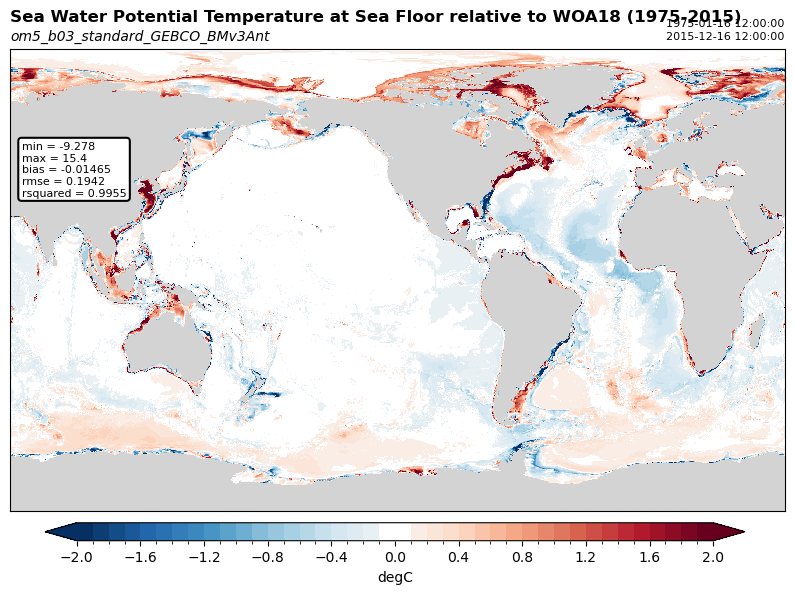

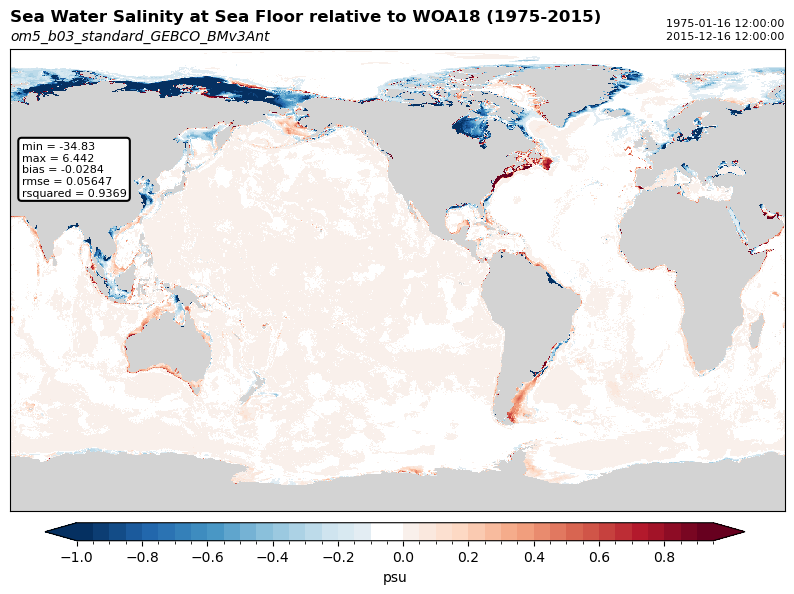

In [19]:
# Setup plot
for v, arange in zip(["tob", "sob"], [(-2, 2.1, 0.1), (-1, 1, 0.05)]):
    
    # Definie geolon and geolat for plotting (use corners!)
    fig = plt.figure(figsize=(10,6))
    ax = plt.subplot(1,1,1, facecolor="lightgray")

    x = ds.geolon_c
    y = ds.geolat_c
    
    # Get colormap
    cmap, norm, boundaries = gen_levs_and_cmap(*arange)
    
    # Run pcolormesh
    cb = plt.pcolormesh(x,y, model[v]-obs[v], cmap=cmap, norm=norm)
    
    # Clean up figure and add labels
    set_annotaions(ax, f"{ds[v].attrs['long_name']} relative to WOA18 (1975-2015)")
    
    # Add statistics
    stats, stats_str = calculate_stats(model[v], obs[v], ds.areacello)
    add_stats_box(ax, stats_str)
    
    # Add colorbar
    add_colorbar(fig, cb, boundaries, ds[v].attrs["units"])
    
    # Save stats
    stats_dict["results"][f"global_{v}"] = stats

### Write Stats to a File

In [20]:
if not "DORA_EXECUTE" in os.environ.keys():
    import yaml
    yml = yaml.dump(stats_dict)
    with open('bottom_property_stats.yaml', 'w') as file:
        file.write(yml)
    file.close()
    print(yml)

metadata:
  created: '2024-04-10T20:31:28.002249'
  endtime: '2015-12-16 12:00:00'
  expName: om5_b03_standard_GEBCO_BMv3Ant
  starttime: '1975-01-16 12:00:00'
results:
  global_sob:
    bias: '-0.0284'
    max: '6.442'
    min: '-34.83'
    rmse: '0.05647'
    rsquared: '0.9369'
  global_tob:
    bias: '-0.01465'
    max: '15.4'
    min: '-9.278'
    rmse: '0.1942'
    rsquared: '0.9955'

